### Initial setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import math
import os
import pathlib
import pickle
import dojolib
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from datastore import DataStore
from matplotlib import pyplot as plt

In [3]:
# logging.basicConfig(level=logging.INFO)

### Plot functions

In [ ]:
def rmse_single_transfer(
    trainsz2rmses_single: dict[int, list[float]],
    trainsz2rmses_xfer: dict[int, list[float]],
    outdir: pathlib.Path,
    output_prefix: str,
    english: bool = False
):
    logging.getLogger('matplotlib').setLevel(logging.WARNING)

    xs = sorted(int(t) for t in trainsz2rmses_single.keys())
    ys = list(np.mean(trainsz2rmses_single[x]) for x in xs)
    ydevs = list(np.std(trainsz2rmses_single[x]) for x in xs)
    ytop = max(ys)
    plt.figure(figsize=(12, 6))
    plt.plot(xs, ys, marker='o', label="Single-user")
    plt.fill_between(
        xs,
        np.array(ys) - np.array(ydevs),
        np.array(ys) + np.array(ydevs),
        alpha=0.2,
    )

    xs = sorted(int(t) for t in trainsz2rmses_xfer.keys())
    ys = list(np.mean(trainsz2rmses_xfer[x]) for x in xs)
    ydevs = list(np.std(trainsz2rmses_xfer[x]) for x in xs)
    plt.plot(xs, ys, marker='o', label="Cross-training")
    plt.fill_between(
        xs,
        np.array(ys) - np.array(ydevs),
        np.array(ys) + np.array(ydevs),
        alpha=0.2,
    )
    ytop = max(max(ys), ytop)

    if english:
        xlabel = "Number of Analyses Used for Training"
    else:
        xlabel = "Número de Análises Utilizadas para Treino"
    os.makedirs(outdir, exist_ok=True)

    # plt.xticks(splits, x_ticks, fontsize=20)
    plt.xticks(xs, [str(int(x)) for x in xs], fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    if english:
        plt.ylabel("Mean RMSE", fontsize=20)
    else:
        plt.ylabel("RMSE Médio", fontsize=20)
    plt.ylim(bottom=0, top=math.ceil(ytop))
    plt.legend(fontsize=20, bbox_to_anchor=(1, 1.034))
    plt.grid(True)
    plt.tick_params(axis="both", which="major", labelsize=20)

    if english:
        sufix = "en"
    else:
        sufix = "pt"

    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.png')
    plt.savefig(output, format='png')

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.png')
    plt.savefig(output, format='png')


In [ ]:
def rmse_all_users(
    user2data: dict[str, tuple],
    outdir: pathlib.Path,
    output_prefix: str,
    choosed_user: str,
    english: bool = False
):
    # class_user2data[user] = (trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single)
    logging.getLogger('matplotlib').setLevel(logging.WARNING)
    plt.figure(figsize=(12, 6))

    ytop = 0
    xcounts = Counter()
    user_mean_rmses_by_size = defaultdict(list)
    for user, data in user2data.items():
        trainsz2rmses_single = data[0]
        xs = sorted(int(t) for t in trainsz2rmses_single.keys())
        if xs[-1] < 25:
            print(f"Skipping user {user} with insufficient data (max train size {xs[-1]})")
            continue
        ys = list(np.mean(trainsz2rmses_single[x]) for x in xs)
        ydevs = list(np.std(trainsz2rmses_single[x]) for x in xs)

        if user == choosed_user:
            for x, y in zip(xs, ys):
                user_mean_rmses_by_size[x].append(y)

        xcounts.update(xs)
        plt.plot(xs, ys, marker='o') #, label=user)
        plt.fill_between(
            xs,
            np.array(ys) - np.array(ydevs),
            np.array(ys) + np.array(ydevs),
            alpha=0.1,
        )
        ytop = max(max(ys), ytop)

    if english:
        xlabel = "Number of Analyses Used for Training"
    else:
        xlabel = "Número de Análises Utilizadas para Treino"
    os.makedirs(outdir, exist_ok=True)

    # plt.xticks(splits, x_ticks, fontsize=20)
    xs = sorted([x for x, v in xcounts.items() if v > 5])
    plt.xlabel(xlabel, fontsize=20)
    plt.xlim((xs[0], xs[-1]))
    plt.xticks(xs, [str(int(x)) for x in xs], fontsize=20)
    if english:
        plt.ylabel("Mean RMSE", fontsize=20)
    else:
        plt.ylabel("RMSE Médio", fontsize=20)
    plt.ylim(bottom=0, top=math.ceil(ytop))
    plt.grid(True)
    plt.tick_params(axis="both", which="major", labelsize=20)

    if english:
        sufix = "en"
    else:
        sufix = "pt"
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.png')
    plt.savefig(output, format='png')

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.png')
    plt.savefig(output, format='png')

    return user_mean_rmses_by_size

In [ ]:
def plot_rmse_summary(
    variable_name: str,
    variable2rmse: dict[int, dict[int, float]],
    outdir: pathlib.Path,
    english: bool = False
):
    values = sorted(variable2rmse.keys())
    all_train_sizes = sorted({ts for rmse_dict in variable2rmse.values() for ts in rmse_dict})

    plt.figure(figsize=(12, 6))
    ytop = 0

    for train_size in all_train_sizes:
        y = [variable2rmse[v].get(train_size, np.nan) for v in values]
        plt.plot(values, y, marker='o', label=f"{train_size}")
        ytop = max(ytop, np.nanmax(y))
    if english:
        options = {
            "num_estimators": "Number of Estimators",
            "learning_rate": "Learning Rate",
            "max_depth": "Max Depth",
        }
    else:
        options = {
            "num_estimators": "Número de Estimadores",
            "learning_rate": "Taxa de Aprendizado",
            "max_depth": "Profundidade Máxima",
        }
    plt.xlabel(options[variable_name], fontsize=20)
    if english:
        plt.ylabel("Mean RMSE", fontsize=20)
    else:
        plt.ylabel("RMSE Médio", fontsize=20)
    plt.grid(True)
    plt.xticks(values, fontsize=16)
    plt.yticks(fontsize=20)
    if english:
        plt.legend(title="Analyses in Training", title_fontsize=18, fontsize=15, ncol=4)
    else:
        plt.legend(title="Análises no Treino", title_fontsize=18, fontsize=15, ncol=4)

    plt.ylim(bottom=0, top=math.ceil(ytop))
    plt.tight_layout()

    os.makedirs(outdir, exist_ok=True)
    if english:
        sufix = "en"
    else:
        sufix = "pt"
    plt.savefig(outdir / f"summary_rmse_{variable_name}_{sufix}.png", format="png")
    plt.savefig(outdir / f"summary_rmse_{variable_name}_{sufix}.pdf", format="pdf")
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.tight_layout()
    output = os.path.join(outdir, f"summary_rmse_{variable_name}_{sufix}_4x3.png")
    plt.savefig(output, format='png')
    output = os.path.join(outdir, f"summary_rmse_{variable_name}_{sufix}_4x3.pdf")
    plt.savefig(output, format='pdf')
    plt.close()

In [ ]:
def plot_feat_importance(
    feat2imps_single: dict[str, list[float]],
    outdir: pathlib.Path,
    output_prefix: str,
    english: bool = False
):
    plt.figure(figsize=(12, 6))
    xs, ys = list(feat2imps_single.keys()), list(feat2imps_single.values())
    ys = list(np.mean(imps) for imps in ys)
    ystotal = sum(ys)
    ys = list(y/ystotal for y in ys)
    assert abs(sum(ys) - 1) < 1e-4

    xs = [dojolib.FEATURE_NAMES.get(x, x) for x in xs]

    # Sort features by importance
    sorted_indices = np.argsort(ys)[::]
    xs = [xs[i] for i in sorted_indices]
    ys = [ys[i] for i in sorted_indices]
    # Show the top 8 most important features and aggregate the remaining ones into "Others"
    top_n = 8
    sorted_indices = np.argsort(ys)[::]
    xs = [xs[i] for i in sorted_indices]
    ys = [ys[i] for i in sorted_indices]
    others_ys = ys[:-top_n]
    xs = xs[-top_n:]
    ys = ys[-top_n:]
    if english:
        xs.insert(0, "Others")
    else:
        xs.insert(0, "Outras")
    ys.insert(0, sum(others_ys))

    os.makedirs(outdir, exist_ok=True)
    if english:
        plt.xlabel("Feature Importance", fontsize=20)
    else:
        plt.xlabel("Importância da Feature", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.barh(xs, ys)
    plt.tight_layout()
    if english:
        sufix = "en"
    else:
        sufix = "pt"
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_2x1_{sufix}.png')
    plt.savefig(output, format='png')

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.png')
    plt.savefig(output, format='png')

In [ ]:
def plot_all_feat(
    all_user_feat2imps: dict[str, dict[str, list[float]]],
    outdir: pathlib.Path,
    output_prefix: str,
    english: bool = False
):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict

    # Group normalized importances by feature
    feat_to_all_imps = defaultdict(list)
    for user_feat in all_user_feat2imps.values():
        feat_values = {feat: np.mean(imps) for feat, imps in user_feat.items()}
        total = sum(feat_values.values())
        if total == 0:
            continue
        normalized = {feat: val / total for feat, val in feat_values.items()}
        for feat, norm_val in normalized.items():
            feat_to_all_imps[feat].append(norm_val)

    feat2mean = {feat: np.mean(vals) for feat, vals in feat_to_all_imps.items()}
    feat2std = {feat: np.std(vals) for feat, vals in feat_to_all_imps.items()}

    top_n = 8
    sorted_feats = sorted(feat2mean.items(), key=lambda x: x[1], reverse=True)
    top_feats = sorted_feats[:top_n]
    other_feats = sorted_feats[top_n:]

    translation_dict = {
        "OpenVAS Severity": "Severidade OpenVAS",
        "Maximum EPSS": "EPSS Máximo",
        "Denial of Service": "Negação de Serviço",
        "SQL Injection": "Injeção SQL",
        "XSS": "XSS",
        "Number of CVEs": "Número de CVEs",
        "Remote Code Execution": "Execução Remota de Código",
        "CVE Age": "Idade da Vuln.",
    }
    xs = []
    for f, _ in top_feats:
        if f == "cve_age":
            label = "CVE Age" if english else "Idade da Vuln."
        else:
            label = dojolib.FEATURE_NAMES.get(f, f)
            if not english and label in translation_dict:
                label = translation_dict[label]
        xs.append(label)

    ys = [feat2mean[f] for f, _ in top_feats]
    yerr = [feat2std[f] for f, _ in top_feats]

    others_mean = sum(feat2mean[f] for f, _ in other_feats)
    others_std = np.sqrt(sum(feat2std[f]**2 for f, _ in other_feats)) if other_feats else 0.0
    xs.append("Others" if english else "Outras")
    ys.append(others_mean)
    yerr.append(others_std)

    # Plot
    os.makedirs(outdir, exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.barh(xs, ys, xerr=yerr, capsize=5)
    plt.gca().invert_yaxis()
    plt.tick_params(axis="both", which="major", labelsize=16)
    plt.xlabel("Feature Importance" if english else "Importância da Feature", fontsize=20)
    plt.xlim(left=0)
    plt.tight_layout()

    sufix = "en" if english else "pt"
    output_pdf = outdir / f"{output_prefix}_2x1_{sufix}.pdf"
    output_png = outdir / f"{output_prefix}_2x1_{sufix}.png"
    plt.savefig(output_pdf, format='pdf')
    plt.savefig(output_png, format='png')

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_4x3_{sufix}.png')
    plt.savefig(output, format='png')
    plt.close()


# Notes on architecture

* `datastore.py` is shared with `django-DefectDojo/dojo/crivo`; this file loads `cve2meta.pkl`, which is built from the data downloaded by the `crivo-init` container.
* `dojolib.py` contains auxiliary classes and functions to help process Dojo data and train the model. `common.py` is the old library used primarily by Shogun (our system to manage Shodan vulnerabilities).
* `clean_dataset.py` is used to organize the data. This file renames variables and includes information to better analyze the data related to each user.
* `settings.py` contains the default variables used by other files.

In [9]:
from settings import (
    RISK_CLASS_GT,
    FEATURES_FILE_CLASS_GT,
    RISK_CLASS_RESIDENTES,
    FEATURES_FILE_CLASS_RESIDENTES,
    RISK_NUM_RESIDENTES,
    FEATURES_FILE_NUM_RESIDENTES,
    CVE2META_PICKLE_FP,
    GRAPHS_OUTDIR,
    FRACTIONS,
    ITERATIONS,
)

In [10]:
ds = DataStore()
ds.load(metadata_fp=CVE2META_PICKLE_FP)

In [ ]:
def process_user(user, df: pd.DataFrame, num_estimators=100, learning_rate=0.3, max_depth=6, max_assessments=100):
    trainsz2rmses_single: dict[int, list[float]] = {}
    trainsz2rmses_xfer: dict[int, list[float]] = {}
    feat2imps_single = {}  # get last one

    for frac in FRACTIONS:
        logging.info("processing frac %f, user %s", frac, user)
        trainsz, rmses_single, feat2imps_single = dojolib.compute_model_accuracy(
            df,
            frac,
            user,
            transfer_learning=False,
            num_estimators=num_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            iterations=ITERATIONS,
            max_assessments=max_assessments,
        )
        trainsz2rmses_single[trainsz] = rmses_single

        trainsz2, rmses_xfer, _feat2imps_xfer = dojolib.compute_model_accuracy(
            df,
            frac,
            user,
            transfer_learning=True,
            num_estimators=num_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            iterations=ITERATIONS,
            max_assessments=max_assessments,
        )
        trainsz2rmses_xfer[trainsz] = rmses_xfer

        assert trainsz == trainsz2

    return user, trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single

In [ ]:
def run_user_model_grid_search(
    features_fp,
    risk_fp,
    files_directory,
    evaluate_user,
    dataset_name,
    ds,
    english=False
):
    # dict_variables = {
    #     "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    #     "num_estimators": [50, 100, 250, 500, 1000],
    #     "learning_rate": [0.1, 0.3, 0.6, 0.9],
    # }
    dict_variables = {
        "learning_rate": [0.3],
    }
    exp_outdir = GRAPHS_OUTDIR / dataset_name
    rmse_save = exp_outdir / "rmse"
    rmse_single = exp_outdir / "rmse_single"
    rmse_feat = exp_outdir / "rmse_feat"
    rmse_individual_feat = exp_outdir / "rmse_individual_feat"
    rmse_summary = exp_outdir / "rmse_summary"
    os.makedirs(exp_outdir, exist_ok=True)

    features, rankings = dojolib.load_features_rankings(features_fp, risk_fp, ds)
    df = dojolib.get_merged_df(features, rankings)
    users = list(df["email"].unique())

    max_assessments = min(
        [len(df[df['email'] == user]) for user in users if len(df[df['email'] == user]) >= 12],
        default=12
    )

    for variable in dict_variables:
        variable2data = {}
        for value in dict_variables[variable]:
            user2data = {}
            featimportance = {}

            for user in users:
                user_df = df[df['email'] == user]
                if len(user_df) < 12:
                    logging.warning(f"user {user} has less than 12, skipping")
                    continue

                pickle_fp = files_directory / f"{variable}_{value}_user2data_{user}.pickle"
                logging.info(f"Processing user {user} with {len(user_df)} assessments")

                if pickle_fp.exists():
                    with open(pickle_fp, "rb") as fd:
                        trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single = pickle.load(fd)
                else:
                    max_depth_value = value if variable == "max_depth" else 6
                    num_estimators = value if variable == "num_estimators" else 100
                    learning_rate = value if variable == "learning_rate" else 0.3

                    _, trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single = process_user(
                        user,
                        df,
                        num_estimators=num_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth_value,
                        max_assessments=max_assessments
                    )
                    with open(pickle_fp, "wb") as fd:
                        pickle.dump((trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single), fd)

                user2data[user] = (trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single)

                if variable == "learning_rate" and value == 0.3:
                    featimportance[user] = feat2imps_single
                    rmse_single_transfer(
                        trainsz2rmses_single,
                        trainsz2rmses_xfer,
                        rmse_single,
                        f"rmse_{variable}_{value}_user_{user}",
                        english=english
                    )
                    plot_feat_importance(
                        feat2imps_single,
                        rmse_individual_feat,
                        f"feat_importance_{variable}_{value}_user_{user}",
                        english=english
                    )

            if variable == "learning_rate" and value == 0.3:
                plot_all_feat(
                    featimportance,
                    rmse_feat,
                    f"feat_importance_{variable}_{value}_all_users",
                    english=english
                )

            user_choosed_rmses = rmse_all_users(
                user2data,
                rmse_save,
                f"rmse_all_users_{variable}_{value}",
                choosed_user=evaluate_user,
                english=english
            )
            variable2data[value] = user_choosed_rmses

        plot_rmse_summary(
            variable_name=variable,
            variable2rmse=variable2data,
            outdir=rmse_summary,
            english=english
        )

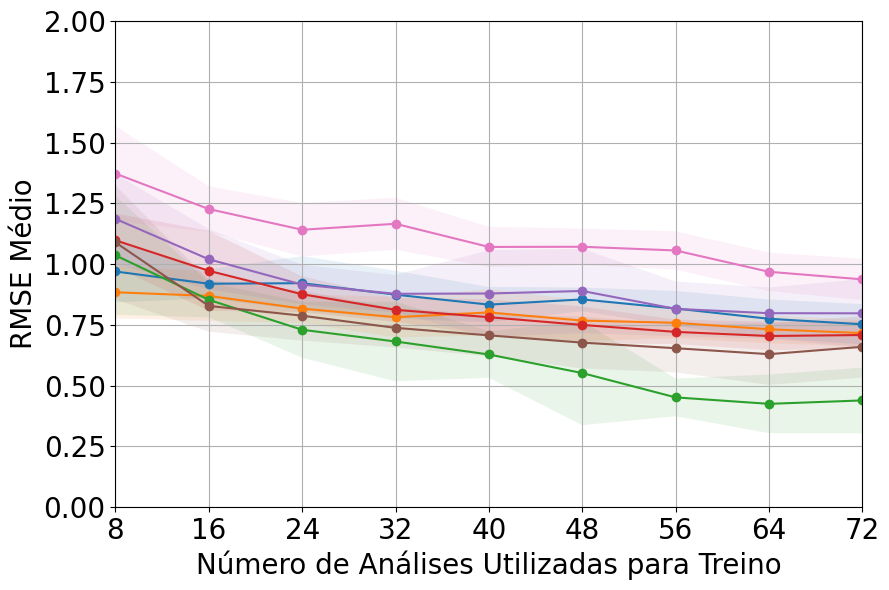

In [ ]:
run_user_model_grid_search(
    FEATURES_FILE_CLASS_GT,
    RISK_CLASS_GT,
    pathlib.Path("rnp-gt-crivo-class-dev-v2"),
    evaluate_user="thbragasouza@gmail.com",
    dataset_name="class_gt",
    ds=ds,  
    english=False
)

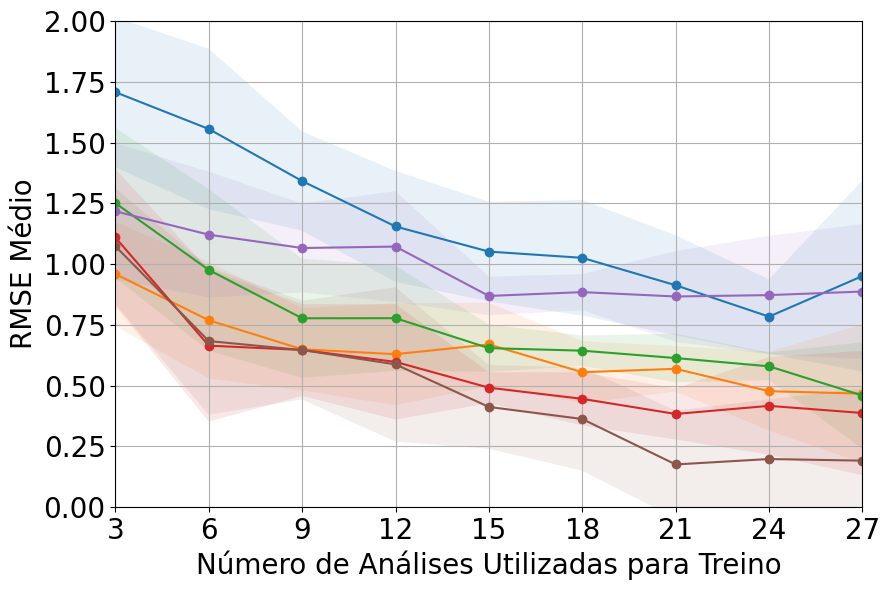

In [ ]:
run_user_model_grid_search(
    FEATURES_FILE_CLASS_RESIDENTES,
    RISK_CLASS_RESIDENTES,
    pathlib.Path("rnp-residentes-class-v2"),
    evaluate_user="ztgustavo2@gmail.com",
    dataset_name="class_residentes",
    ds=ds,
    english=False
)

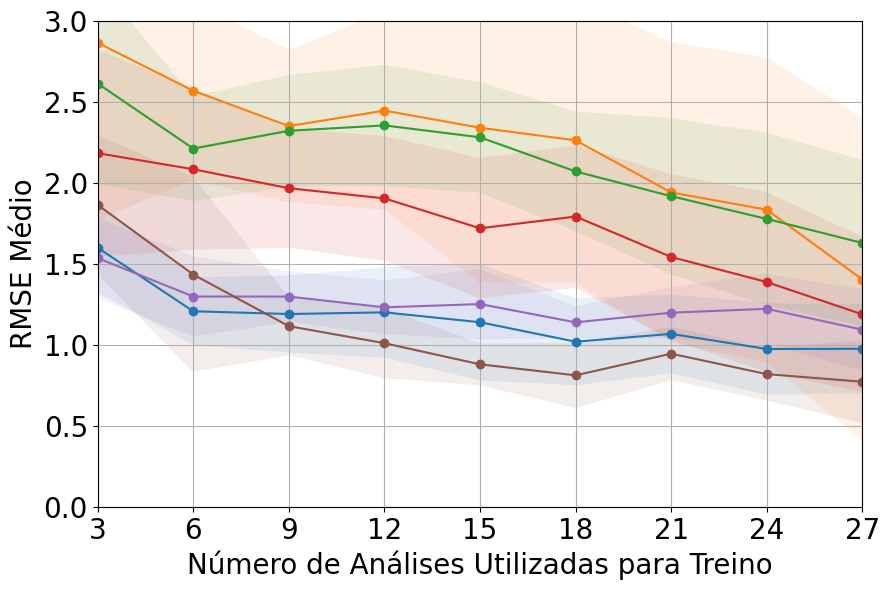

In [ ]:
run_user_model_grid_search(
    FEATURES_FILE_NUM_RESIDENTES,
    RISK_NUM_RESIDENTES,
    pathlib.Path("rnp-residentes-num-v2"),
    evaluate_user="paulo.simonato@hotmail.com",
    dataset_name="num_residentes",
    ds=ds,
    english=False
)